# Developing match up function v2

- Should work on altimetry & waveriders!

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rompy
from rompy import utils ## Should we import utils in __init__.py?
from shapely.geometry import MultiPoint,Point
%matplotlib inline

xr.set_options(display_style = 'text')

In [2]:
cat = rompy.cat
model_ds = cat.csiro.swan.swan_perth_fc.map(fcdate='2020-12-21').to_dask()

x = model_ds.longitude.values
y = model_ds.latitude.values 
xx,yy = np.meshgrid(x,y)
points = MultiPoint(list(map(Point,zip(xx.ravel(),yy.ravel())))) 
geom = points.convex_hull.buffer(0.01).simplify(tolerance=0.01)
geom
model_ds

<xarray.Dataset>
Dimensions:    (latitude: 300, longitude: 160, time: 121)
Coordinates:
  * time       (time) datetime64[ns] 2020-12-21 ... 2020-12-26
  * longitude  (longitude) float32 115.0 115.0 115.0 115.0 ... 115.8 115.8 115.8
  * latitude   (latitude) float32 -33.0 -32.99 -32.99 ... -31.51 -31.51 -31.5
Data variables:
    depth      (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    ubot       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    hs         (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    hswe       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    theta0     (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    tps        (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    tm01       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    xwnd       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    ywnd       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.5
    History:                         Created with agioncmd version 1.5
    Directional_convention:          nautical
    project:                         SWAN
    run:                             
    DODS_EXTRA.Unlimited_Dimension:  time

In [3]:
ds_alt=rompy.cat.aodn.nrt_wave_altimetry(startdt='2020-12-21',
                                         enddt='2020-12-26',
                                         geom=geom.to_wkt(),
                                         ds_filters={'subset':['SWH_C'],'sort':['TIME']}).to_dask()

In [4]:
out_ds = rompy.utils.find_matchup_data(ds_alt,model_ds,{'swh_c':'hs'},time_thresh=None,KDtree_kwargs={})
out_ds

<xarray.Dataset>
Dimensions:          (observation: 45)
Coordinates:
    time             (observation) datetime64[ns] 2020-12-23T21:00:00 ... 202...
    longitude        (observation) float32 115.0 115.0 115.1 ... 115.3 115.3
    latitude         (observation) float32 -32.73 -32.78 ... -32.89 -32.94
Dimensions without coordinates: observation
Data variables:
    meas_swh_c       (observation) float32 1.272 0.938 1.346 ... nan nan nan
    model_hs         (observation) float32 1.4 1.366 1.376 ... 1.769 1.709 1.662
    model_time       (observation) datetime64[ns] 2020-12-23T21:00:00 ... 202...
    model_longitude  (observation) float32 115.0 115.0 115.1 ... 115.3 115.3
    model_latitude   (observation) float32 -32.73 -32.78 ... -32.89 -32.94
    dist             (observation) float64 0.001797 0.001888 ... 0.0005644
Attributes:
    grid:     regular

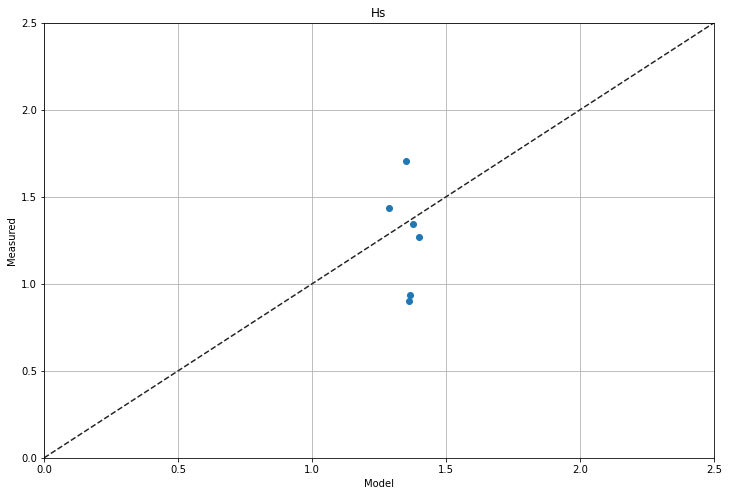

In [5]:
fig, ax  = plt.subplots(figsize=(12,8))

ax.scatter(out_ds['model_hs'],out_ds['meas_swh_c'])
ax.plot([0,3],[0,3],ls='--',c='#252525')
ax.set_ylim(0,2.5)
ax.set_xlim(0,2.5)
ax.set_xlabel('Model')
ax.set_ylabel('Measured')
ax.set_title('Hs')
ax.grid()